In [8]:
#  256 NNANN, random select 8 for test, the rest 248 5-mers for training

all_5mers=[]
for base1 in ["A","C","G","T"]:
    for base2 in ["A","C","G","T"]:
        for base4 in ["A","C","G","T"]:
            for base5 in ["A","C","G","T"]:
                all_5mers.append("%s%sA%s%s" %(base1,base2,base4,base5))
                
import random

random.seed(0)
# Randomly select 8 5-mers
test_5mers = random.sample(all_5mers, 8)

train_5mers = [kmer for kmer in all_5mers if kmer not in test_5mers]
# Display the selected 8-mers
print(test_5mers)

['TAACC', 'TCACT', 'ACACA', 'GAACA', 'TTAGA', 'TAATT', 'GCAGT', 'TTACA']


In [10]:
#generate training data from IVET containing 248 5mers
IEVT_248_5mers_A=open("/home/wuyou/Projects/Os_AD/data/IVET_248_5mers_A.feature","w")
IEVT_248_5mers_m6A=open("/home/wuyou/Projects/Os_AD/data/IVET_248_5mers_m6A.feature","w")
with open("/home/wuyou/Projects/Os_AD/data/unmod_A_length_1000") as f:
    count=0
    for line in f:
        sequence_5mer=line.split("\t")[3]
        if sequence_5mer in train_5mers:
            IEVT_248_5mers_A.writelines(line)
            count+=1
        if count>4e5:
            break

IEVT_248_5mers_A.close()

with open("/home/wuyou/Projects/Os_AD/data/m6A_length_1000") as f:
    count=0
    for line in f:
        sequence_5mer=line.split("\t")[3]
        if sequence_5mer in train_5mers:
            IEVT_248_5mers_m6A.writelines(line)
            count+=1
        if count>4e5:
            break
            
IEVT_248_5mers_m6A.close()



#generate test data from Curlcake containing 
Curlcake_8_5mers_A=open("/home/wuyou/Projects/paper/m6A/feature/Curlcake_8_5mer_A.feature","w")
Curlcake_8_5mers_m6A=open("/home/wuyou/Projects/paper/m6A/feature/Curlcake_8_5mer_m6A.feature","w")
with open("/home/wuyou/Projects/paper/m6A/feature/A") as f:
    count=0
    for line in f:
        sequence_5mer=line.split("\t")[3]
        if sequence_5mer in test_5mers:
            Curlcake_8_5mers_A.writelines(line)
            count+=1
        if count>4e4:
            break

Curlcake_8_5mers_A.close()

with open("/home/wuyou/Projects/paper/m6A/feature/m6A") as f:
    count=0
    for line in f:
        sequence_5mer=line.split("\t")[3]
        if sequence_5mer in test_5mers:
            Curlcake_8_5mers_m6A.writelines(line)
            count+=1
        if count>4e4:
            break
            
Curlcake_8_5mers_m6A.close()




In [16]:
#roc&pr train on  Os_AD probability  test on untrained genes
import pickle
import numpy as np
import torch
import torchvision
import torch.nn as nn
import time
import traceback
import pandas as pd

from sklearn import metrics

from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from matplotlib import pyplot as plt

from torch.utils import data as torch_data
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from scipy import interpolate
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve
from plotnine import *
import argparse


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    #train_dir="m5C/feature/train/"
    #test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}   

class BahdanauAttention(nn.Module):
    """
    input: from RNN module h_1, ... , h_n (batch_size, seq_len, units*num_directions),
                                    h_n: (num_directions, batch_size, units)
    return: (batch_size, num_task, units)
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class NN(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(NN,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x

count_dict_overlap=pickle.load(open("/home/wuyou/Projects/Os_AD/count_dict_overlap_m6A_unmod.dict","rb"))





class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = NN(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def train():
    print("Start training...")

    for epoch in range(1000):

        torch.cuda.empty_cache()

        y_train = []
        y_pred = []
        tic=datetime.datetime.now()
        for i,(batch_x, batch_y) in enumerate(train_loader):
            signal,kmer,mean,std,intense,dwell,base_quality=batch_x
            signal, batch_y = Variable(signal.to(device)).to(torch.float32), Variable(batch_y.to(device)).to(torch.long)
            kmer = Variable(kmer.to(device)).to(torch.long)
            mean=Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1,features)

            out = model(signal,kmer,mean,std,intense,dwell,base_quality)

            optimizer.zero_grad() 

            batch_size,out_channels=out.size()    #[300, 1, 2]  to [300,2]
            out=out.view(batch_size,out_channels)

            loss = loss_func(out, batch_y)
            loss.backward()
            optimizer.step()


            pred = torch.max(out, 1)[1]
            train_correct = (pred == batch_y).sum()

            y_pred.extend(pred.cpu())
            y_train.extend(list(batch_y.cpu().numpy()))
            #print(y_train, y_pred)
            if i % 100 ==0:

                train_acc = metrics.accuracy_score(y_train, y_pred)

                #test_acc,tr_auc=test(model)
                test_acc,tr_auc=0,0
                
                toc = datetime.datetime.now()
                print('Epoch {}-{} Train acc: {:.6f},Test Acc: {:.6f},AUC: {:.6f},time{:}'.format(epoch,i,  train_acc,test_acc ,tr_auc,toc-tic))

                tic = datetime.datetime.now()
                y_train = []
                y_pred = []


                #torch.save(model, 'model/m6A_Os_AD_median_mad_2.21.pkl')



def predict(model,dataset,cut_off_threshold):

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=2000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"C",1:"m5C"}

        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            print(cut_off_threshold[0],len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            return fpr,tpr,precision,recall,roc_auc,pr_auc
            
    except Exception as e:
        print(e)
        traceback.print_exc()

device= cpu
loading data...


In [18]:
################median mad####################################################    
import datetime
train_x,train_y=[],[]
f=open("/home/wuyou/Projects/Os_AD/data/IVET_248_5mers_A.feature")
count=0
for i,line in enumerate(f):

    line=line.rstrip()
    items=line.split("\t")
    contig=items[1]

    if contig in count_dict_overlap:

        continue

    
    count+=1
    if count>4e5:
        break
        
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    train_x.append(x)
    train_y.append(0)
f.close()

f=open("/home/wuyou/Projects/Os_AD/data/IVET_248_5mers_m6A.feature")
count=0
for i,line in enumerate(f):

    line=line.rstrip()
    items=line.split("\t")
    
    contig=items[1]
    if contig in count_dict_overlap:
        continue

    count+=1
    if count>4e5:
        break
    
        
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    train_x.append(x)
    train_y.append(1)
f.close()

print(217,len(train_y))

dataset=MyDataset(train_x,train_y)
train_loader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=50, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

train()

217 60189
Start training...
Epoch 0-0 Train acc: 0.860000,Test Acc: 0.000000,AUC: 0.000000,time0:00:01.297249
Epoch 0-100 Train acc: 0.858400,Test Acc: 0.000000,AUC: 0.000000,time0:00:26.514138
Epoch 0-200 Train acc: 0.859800,Test Acc: 0.000000,AUC: 0.000000,time0:00:19.015012
Epoch 0-300 Train acc: 0.861400,Test Acc: 0.000000,AUC: 0.000000,time0:00:19.494873
Epoch 0-400 Train acc: 0.868600,Test Acc: 0.000000,AUC: 0.000000,time0:00:19.407706
Epoch 0-500 Train acc: 0.870000,Test Acc: 0.000000,AUC: 0.000000,time0:00:19.191062
Epoch 0-600 Train acc: 0.875800,Test Acc: 0.000000,AUC: 0.000000,time0:00:18.812466
Epoch 0-700 Train acc: 0.870000,Test Acc: 0.000000,AUC: 0.000000,time0:00:17.714489
Epoch 0-800 Train acc: 0.867800,Test Acc: 0.000000,AUC: 0.000000,time0:00:18.349148
Epoch 0-900 Train acc: 0.868200,Test Acc: 0.000000,AUC: 0.000000,time0:00:18.546183
Epoch 0-1000 Train acc: 0.872400,Test Acc: 0.000000,AUC: 0.000000,time0:00:18.520838
Epoch 0-1100 Train acc: 0.851800,Test Acc: 0.0000

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe66acff940>
Traceback (most recent call last):
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/wuyou/.conda/envs/sc/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
Keyboa

KeyboardInterrupt: 

0.5 2000
0.4 1842
0.3 1688
0.2 1437
0.1 958


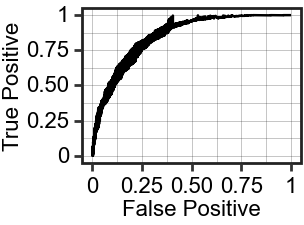

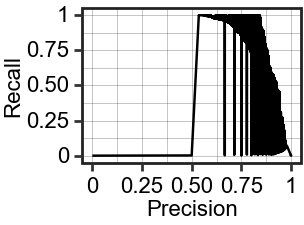

In [19]:
################median mad####################################################    
x_test_median_mad,y_test_median_mad=[],[]
f=open("/home/wuyou/Projects/paper/m6A/feature/Curlcake_8_5mer_A.feature")
for i,line in enumerate(f):
    if i>2e3:
        break
        pass
    line=line.rstrip()
    items=line.split("\t")
    contig=items[1]

    
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
f.close()

f=open("/home/wuyou/Projects/paper/m6A/feature/Curlcake_8_5mer_m6A.feature")
for i,line in enumerate(f):
    if i>2e3:
        break
        pass
    line=line.rstrip()
    items=line.split("\t")
    
    contig=items[1]

        
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(1)
f.close()
        
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')
    parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    args = parser.parse_args()
  
    
    fprs,tprs,precisions,recalls,normalization_roc,normalization_pr=[],[],[],[],[],[]
    
    dataset=MyDataset(x_test_median_mad,y_test_median_mad)
    
    #model= torch.load('model/m6A_Os_AD_median_mad_2.21.pkl')
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.5,0.5])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)

    normalization_roc.extend(["0.5 0.5 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.5 0.5 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.4,0.6])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    normalization_roc.extend(["0.4 0.6 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.4 0.6 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.3,0.7])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    normalization_roc.extend(["0.3 0.7 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.3 0.7 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.2,0.8])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    normalization_roc.extend(["0.2 0.8 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.2 0.8 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.1,0.9])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    normalization_roc.extend(["0.1 0.9 AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["0.1 0.9 AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    
    
    roc_auc = auc(fpr, tpr)
    
    data=pd.DataFrame(dict(fpr=fprs,tpr=tprs,normalization=normalization_roc)) 
    p1 = (ggplot()
        +geom_line(data,aes(x="fpr",y = "tpr"))
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=8,family="Arial",color="black"),
            axis_title_x=element_text(size=8,family="Arial",color="black"),
            axis_title_y=element_text(size=8,family="Arial",color="black"),
            legend_position = "none",figure_size=[1.52,1.13])
        +labs(x = "False Positive", y ="True Positive")
                 
        )
    print(p1)
            
    data=pd.DataFrame(dict(precision=precisions,recall=recalls,normalization=normalization_pr)) 
    p2 = (ggplot()
        +geom_line(data,aes(x="precision",y = "recall"))
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=8,family="Arial",color="black"),
            axis_title_x=element_text(size=8,family="Arial",color="black"),
            axis_title_y=element_text(size=8,family="Arial",color="black"),
            legend_position =  "none",figure_size=[1.52,1.13])
        +labs(x = "Precision", y ="Recall")
     
        )
    print(p2)


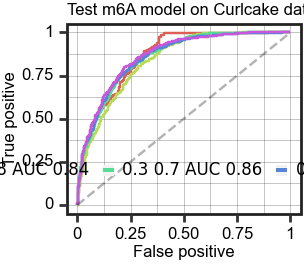

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 1.52 x 1.33 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/test_m6A_on_curlcake_dataset_ROC.pdf


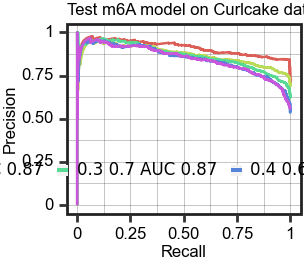

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 1.52 x 1.33 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/test_m6A_on_curlcake_dataset_PR.pdf


In [20]:
#a=matplotlib.text.Text()
#a.set_family("Arial")
data=pd.DataFrame(dict(fpr=fprs,tpr=tprs,normalization=normalization_roc)) 
p1 = (ggplot()
        +geom_line(data,aes(x="fpr",y = "tpr",group="normalization",color='normalization'))
        +geom_line(pd.DataFrame(dict(x=[0,1],y=[0,1])),aes(x="x",y="y"),linetype="dashed",alpha=0.3)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            figure_size=[1.52,1.33],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.60,0.4),
            legend_key_size=4) #change legend text font size
        +labs(x = "False positive", y ="True positive")
        +guides(color = guide_legend(title = "Probability cutoff"))
        +ggtitle("Test m6A model on Curlcake dataset")

)
print(p1)
p1.save('figure/test_m6A_on_curlcake_dataset_ROC.pdf')

data=pd.DataFrame(dict(precision=precisions,recall=recalls,normalization=normalization_pr)) 
p2 = (ggplot()
        #+geom_line(pd.DataFrame(dict(x=[1,0],y=[0,1])),aes(x="x",y="y"),linetype="dashed")
        +geom_line(data,aes(x="recall",y = "precision",group="normalization",color='normalization'))
        
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            figure_size=[1.52,1.33],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.45,0.4), 
            legend_key_size=4) #change legend text font size)
        +labs(x = "Recall", y ="Precision")
        +ggtitle("Test m6A model on Curlcake dataset")
        +guides(color = guide_legend(title = "Probability cutoff"))
        )
print(p2)
p2.save('figure/test_m6A_on_curlcake_dataset_PR.pdf')